In [40]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))


from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

## 0. Read and inspect data files

In [41]:
input_path = '../Data/'

feature_file = 'Fingerprints/Morgan_Fingerprints_Frequency_Size50.csv'
feature_file = 'Fingerprints/Morgan_Fingerprints_Frequency_Size100.csv'

features_file_2 =  'leffingwell_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set.csv' 
training_task_file = 'TrainingData_mixturedist.csv'

# Mordred features
features_1 = pd.read_csv(os.path.join(input_path, feature_file), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))


# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

#### All features are positive!

#### Standard transform:

In [42]:
# Map CID to 96 dim features:
CID2features_morgan =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_2[i] for i, CID in enumerate(features_CIDs)}

In [43]:
X_m, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features_morgan, method = 'sum')
X_l, _, _, _ = format_Xy(training_set,  mixtures_IDs, CID2features_leffingwell, method = 'sum')

In [44]:
# Convert the input pairs to a suitable format for training
X_pairs_m = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_m])
X_pairs_l = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_l])

y_true = np.array(y)

In [45]:
distances_m = [get_euclidean_distance(m[0], m[1]) for m in X_m]
similarities_m = [get_cosine_similarity(m[0], m[1]) for m in X_m]
angles_m = [get_cosine_angle(m[0], m[1]) for m in X_m] 

distances_l = [get_euclidean_distance(m[0], m[1]) for m in X_l]
similarities_l = [get_cosine_similarity(m[0], m[1]) for m in X_l]
angles_l = [get_cosine_angle(m[0], m[1]) for m in X_l] 

In [46]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [47]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [48]:
### add all information above
X_features = np.hstack( (X_pairs_l, X_pairs_m,
                        np.array(distances_m).reshape(500, 1), 
                        np.array(similarities_m).reshape(500, 1), 
                        np.array(angles_m).reshape(500, 1), 
                        np.array(distances_l).reshape(500, 1), 
                        np.array(similarities_l).reshape(500, 1), 
                        np.array(angles_l).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures).reshape(500,2), 
                        data_arr))

### Correlation between combined mixture embeddings and eperimetal values

In [49]:
# dist_corr = np.corrcoef(distances_l, y_true)[0, 1]
dist_corr = np.corrcoef(distances_m, y_true)[0, 1]

print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.25304750693826317


In [50]:
# sim_corr = np.corrcoef(similarities_l, y_true)[0, 1]
sim_corr = np.corrcoef(similarities_m, y_true)[0, 1]

print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.37925804275512953


In [51]:
# sim_corr = np.corrcoef(angles_l, y_true)[0, 1]
sim_corr = np.corrcoef(angles_m, y_true)[0, 1]

print('R (Vector angle v.s. Experimental Value): ', sim_corr)

R (Vector angle v.s. Experimental Value):  0.43611123970179044


----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [52]:
n_folds = 10
seed = 314159

In [53]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    # rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=seed
)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    # xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        reg_alpha=0,
        reg_lambda=1,
        random_state=seed
    )
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [54]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,0.577300,0.585557,0.604167
300,Snitz 1,1,3,0.651042,0.680120,0.642103,0.651042
0,Snitz 1,1,5,0.505208,0.533849,0.455606,0.505208
1,Snitz 1,1,6,0.411458,0.534425,0.441121,0.411458
50,Snitz 1,1,7,0.562500,0.625180,0.546525,0.562500


In [55]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.609
Random Forest - RMSE: 0.124

XGBoost - R: 0.530
XGBoost - RMSE: 0.135


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

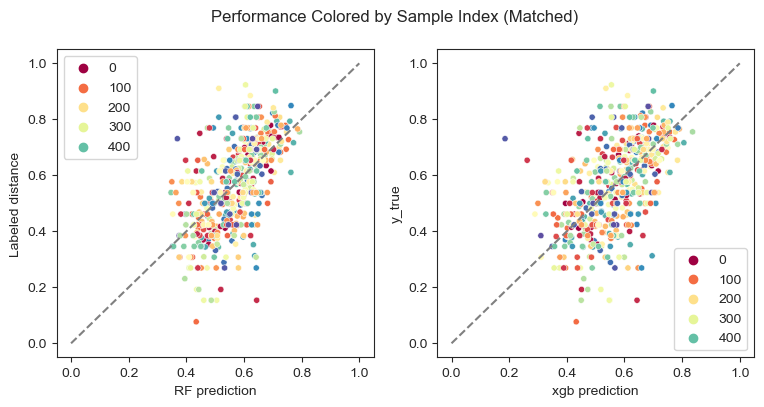

In [56]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()